In [1]:
import numpy as np
from matplotlib import pyplot as plt
from my_utils import *
from sigproc_kit import *
import random
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from IPython.display import display, Math, Latex


<IPython.core.display.Math object>

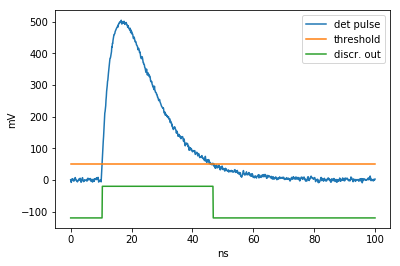

t1 : 10.317 ns, tot : 36.515 ns


In [2]:
##################################################
##             basic discriminator              ##
##################################################


t = np.linspace(0,100e-9,1000) # be sure to make not to few steps, if you have a sharp IR

Q = 200e-12
tau1 = 5e-9
tau2 = 10e-9
delay = 10e-9

det = detector_signal_function(t, Q, tau1, tau2, delay)

noise = 5e-3
noise_bw = 1e9

hyst = 5e-3

y = add_noise(t,det,rms=noise,bw=noise_bw)

thresh = 50e-3

discr, t1, tot = discriminate(t,y,thresh,hysteresis=hyst)

display(Math(r'f(t) = \frac{1}{\tau_1-\tau_2}\cdot \left(e^{-\frac{t}{\tau_1}} - e^{-\frac{t}{\tau_2}}\right)'))

plt.plot(t*1e9,y*1e3,label="det pulse")
plt.plot(t*1e9,y*0+thresh*1e3,label="threshold")
plt.plot(t*1e9,discr*100-120,label="discr. out")
plt.xlabel("ns")
plt.ylabel("mV")
plt.legend()
plt.show()

print("t1 : {:3.3f} ns, tot : {:3.3f} ns".format(t1*1e9,tot*1e9))

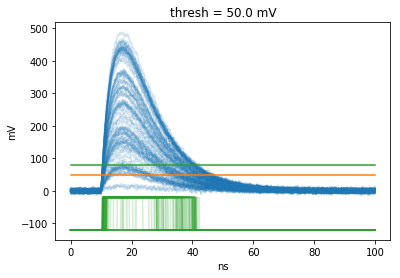

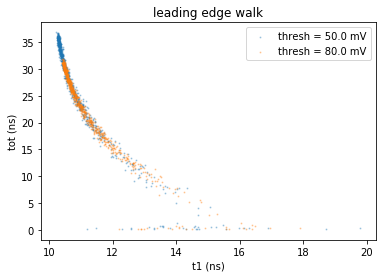

In [3]:
t1_a_list  = []
tot_a_list = []
t1_b_list  = []
tot_b_list = []

thresh_a = 50e-3
#thresh_b = 100e-3
thresh_b = 80e-3 # empirical better results

for i in range(0,1000):

  y = random.random()*det 
  y = add_noise(t,y,rms=noise,bw=noise_bw)
  discr, t1_a, tot_a = discriminate(t,y,thresh_a,hysteresis=hyst)
  discr, t1_b, tot_b = discriminate(t,y,thresh_b,hysteresis=hyst)
  t1_a_list  += [t1_a]
  tot_a_list += [tot_a]
  t1_b_list  += [t1_b]
  tot_b_list += [tot_b]
  if (i < 80):
    alpha = 0.2
    plt.plot(t*1e9,y*1e3,label="det pulse",color=colors[0],alpha=alpha)
    plt.plot(t*1e9,discr*100-120,label="discr. out",color=colors[2],alpha=alpha)
    
plt.plot(t*1e9,y*0+thresh_a*1e3,label="threshold",color=colors[1])
plt.plot(t*1e9,y*0+thresh_b*1e3,label="threshold",color=colors[2])
plt.xlabel("ns")
plt.ylabel("mV")
plt.title("thresh = {:3.1f} mV".format(thresh*1e3))
plt.show()
    
t1_a  = np.array(t1_a_list)
tot_a = np.array(tot_a_list)
t1_b  = np.array(t1_b_list)
tot_b = np.array(tot_b_list)

plt.scatter(t1_a*1e9,tot_a*1e9, s=1, alpha=0.3, label="thresh = {:3.1f} mV".format(thresh_a*1e3))
plt.scatter(t1_b*1e9,tot_b*1e9, s=1, alpha=0.3, label="thresh = {:3.1f} mV".format(thresh_b*1e3))
plt.legend()
plt.xlabel("t1 (ns)")
plt.ylabel("tot (ns)")
plt.title("leading edge walk")
plt.show()

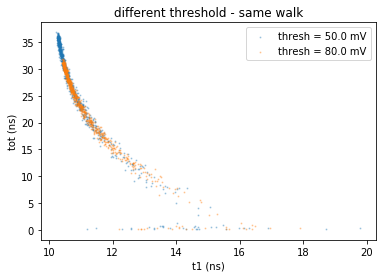

In [4]:
plt.scatter(t1_a*1e9,tot_a*1e9, s=1, alpha=0.3, label="thresh = {:3.1f} mV".format(thresh_a*1e3))
plt.scatter(t1_b*1e9,tot_b*1e9, s=1, alpha=0.3, label="thresh = {:3.1f} mV".format(thresh_b*1e3))
plt.legend()
plt.xlabel("t1 (ns)")
plt.ylabel("tot (ns)")
plt.title("different threshold - same walk")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in multiply
  


<IPython.core.display.Math object>

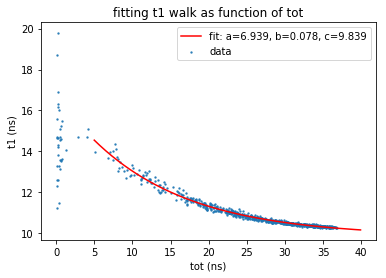

In [5]:

def t1_walk(x, a,b,c):
    return a*np.exp(-b*(x))+c


xdata = tot_a*1e9
ydata = t1_a*1e9

mask = ~np.isnan(xdata) & ~np.isnan(ydata) & (xdata >5)
xdata = xdata[mask]
ydata = ydata[mask]

plot_x = np.arange(5,40,0.1)

popt, pcov = curve_fit(t1_walk, xdata, ydata, p0 = [1,1,1])

display(Math(r'walk(tot) = a\cdot e^{-b\cdot tot}+c '))

plt.plot(plot_x, t1_walk(plot_x, *popt), 'r-',         label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.scatter(tot_a*1e9,t1_a*1e9, s=2, alpha=0.8,label="data")
plt.ylabel("t1 (ns)")
plt.xlabel("tot (ns)")
plt.legend()
plt.title("fitting t1 walk as function of tot")
plt.show()


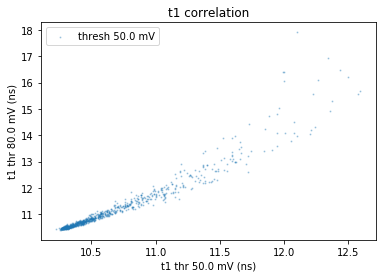

In [6]:
##################################################
##              delay line CF idea              ##
##################################################


plt.scatter(t1_a*1e9,t1_b*1e9, s=1, alpha=0.3, label="thresh {:3.1f} mV".format(thresh_a*1e3))
#plt.scatter(t1_b*1e9,tot_b*1e9, s=1, alpha=0.3, label="thresh 100 mV")
plt.legend()
plt.xlabel("t1 thr {:3.1f} mV (ns)".format(thresh_a*1e3))
plt.ylabel("t1 thr {:3.1f} mV (ns)".format(thresh_b*1e3))
plt.title("t1 correlation")
plt.show()

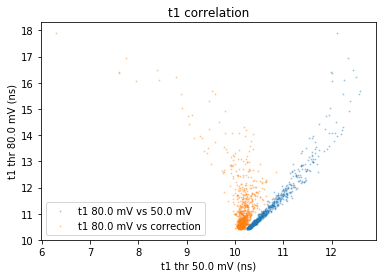

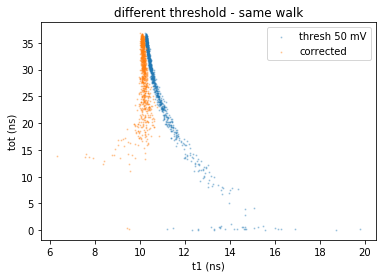

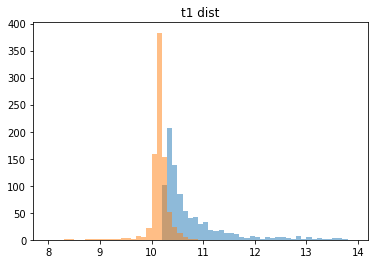

t1 std
1.03098065605
t1 corrected std
0.293123426212


In [7]:
##################################################
##              delay line CF idea              ##
##################################################

corrected = t1_a - 1*(t1_b - t1_a)

plt.scatter(t1_a*1e9,t1_b*1e9, s=1, alpha=0.3, label="t1 {:3.1f} mV vs {:3.1f} mV".format(thresh_b*1e3,thresh_a*1e3))
plt.scatter(corrected*1e9,t1_b*1e9, s=1, alpha=0.3, label="t1 {:3.1f} mV vs correction".format(thresh_b*1e3))
plt.legend()
plt.xlabel("t1 thr {:3.1f} mV (ns)".format(thresh_a*1e3))
plt.ylabel("t1 thr {:3.1f} mV (ns)".format(thresh_b*1e3))
plt.title("t1 correlation")
plt.show()

plt.scatter(t1_a*1e9,tot_a*1e9, s=1, alpha=0.3, label="thresh 50 mV")
#plt.scatter(t1_b*1e9,tot_b*1e9, s=1, alpha=0.3, label="thresh 100 mV")
plt.scatter(corrected*1e9,tot_a*1e9, s=1, alpha=0.3, label="corrected")
plt.legend()
plt.xlabel("t1 (ns)")
plt.ylabel("tot (ns)")
plt.title("different threshold - same walk")
plt.show()


plt.hist(remove_nan(t1_a)*1e9,      bins = np.arange(8,14,0.1), alpha=0.5) 
plt.hist(remove_nan(corrected)*1e9, bins = np.arange(8,14,0.1), alpha=0.5) 
plt.title("t1 dist") 
plt.show()

print("t1 std")
print(np.std(remove_nan(t1_a)*1e9))
print("t1 corrected std")
print(np.std(remove_nan(corrected)*1e9))